This notebook is based on the [tutorial of Samy Zafrany](https://www.samyzaf.com/ML/rl/qmaze.html ), but we adapted it for pytorch instead of keras. The keras code was written by adapting [Eder Santana's](https://gist.github.com/EderSantana) 
[Keras plays catch code example](https://edersantana.github.io/articles/keras_rl/) for maze solving.

# Deep Reinforcement Learning for Maze Solving

In this notebook we will try to explain the main ideas behind deep reinforcement learning
(also called deep **Q-learning**) by a simple application for solving classical mazes.

<img src="dcq.gif" style="max-width: 50%;" />


## Background
Reinforcement learning is a machine learning technique for solving problems by a
feedback system (rewards and penalties)
applied on an **agent** which operates in an **environment** and needs to move through
a series of states in order to reach a pre-defined final state.
A classical example is a rat (agent) which is trying to find the shortest route from
a starting cell to a target cheese cell in a maze (environment).
The agent is **experimenting** and **exploiting** past experiences (**episodes**) in
order to achieve its goal.
It may fail again and again, but hopefully, after lots of trial and error
(and seeing the resulting rewards and penalties) it will arrive to the solution of the problem.
The solution will be reached if the agent finds the optimal sequence of states
in which the **accumulated sum of rewards** is maximal.


Note that it may happen that in order to reach the goal,
the agent will have to endure many penalties (negative rewards) on its way.
For example, the rat in the above maze will get a small penalty for every legal move.
The reason for that is that we want it to get to the target cell in the shortest possible path.
However, the shortest path to the target cheese cell is sometimes long and winding,
and our agent (the rat) may have to endure many penalties until it gets to the "cheese"
(sometimes called "delayed reward").

## Maze Solving
A simple maze consists of a rectangular grid of cells (usually square),
a rat, and a "cheese" cell.

<img src="maze10x10.gif" style="max-width: 30%;" />


To keep it as simple as possible:
1. We will use small 7x7, 8x8, and 10x10 mazes as examples.
2. The cheese is always at the bottom right cell of the maze.
3. We have two types of cells: free cells (white) and occupied cells (red or black).
4. The rat can start from any free cell and is allowed to travel on the free cells only.

## Load Libraries

In [1]:
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
import torch
from torch.nn import Sequential, Linear, PReLU
from torch.optim import SGD , Adam
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

A maze can be easily coded as a Numpy matrix, e.g. a 10x10 maze:

In [8]:
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.],
    [ 1.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.],
    [ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.]
])

This is how it looks on a **tkinter** canvas.
The rat is starting at cell (0,0) (top-left cell)
and the cheese is placed at cell (9,9) (bottom-right cell)



<img src="maze1a.png" width="300" align="center">



Note the usual Numpy row and column numbering conventions:
each cell is represented by a pair of integers **(row, col)**
where **row** is the row number (counted from the top)
and **col** is the column number (counted left to right).

## Environment Description
A framework for an **MDP** (Markov Decision Process) consists of an **environment**
and an **agent** which acts in this environment.
In our case the environment is a classical square maze with three types of cells:
1. **Occupied cells**
2. **Free cells**
3. **Target Cell** (in which the cheese is located)

Our agent is a **rat** (or a mouse if you prefer) which is allowed to move only on free cells,
and whose sole purpose in life is to get to the cheese.


<ol>
<li> We have exactly 4 actions which we can encode as integers 0-3:
<ul>
<li> 0 - left
<li> 1 - up
<li> 2 - right
<li> 3 - down
</ul>

    
<img src="maze1b.png" width="300" align="center">


In our model, the rat will be "encouraged" to find the shortest path to the target cell
by a simple rewarding scheme:

Our rewards will be ranging from -1.0 to 1.0.

- Each move from one state to the next state will be rewarded by a positive or a negative (penalty) amount:
    - Each move will cost the rat **-0.04 points**. 
        This should discourage the rat from wandering around and get to the cheese in the shortest route possible.
    - The **maximal reward of 1.0 points** is given when the rat hits the cheese cell.
    - An attempt to enter a blocked cell ("red" cell) will cost the rat **-0.75** points.
        This is a severe penalty, so hopefully the rat will learn to avoid it completely.
        Note that this move is invalid and will not be executed; however it will incur a -0.75 penalty if attempted.
    - Same rule holds for an attempt to move outside the maze boundaries: **-0.75 points penalty** .
    - The rat will be penalized by **-0.25 points** for any move to a cell which it has already visited.
         This is clearly a counterproductive action that should not be taken.
    - To avoid infinite loops and senseless wandering, the game is ended (**lose**) once the total reward of the rat is below the negative threshold: (`-0.5 * maze.size`). We assume that under this threshold, the rat has "lost its way" and already made too many errors from which it has learnt enough, and should proceed to a new fresh game.



In [9]:
## Here are our main constants:
visited_mark = 0.8  # Cells visited by the rat will be shown by gray 0.8
rat_mark = 0.5      # The current rat cell will be shown by gray 0.5
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)

# Exploration factor
epsilon = 0.1

## Exploitation vs. Exploration
The story of **epsilon**, also called **exploration factor**
is part of the larger **Q-learning** story:

1. The main objective of Q-training is to develope a **policy** $\boldsymbol{\pi}$
for navigating the maze successfully.
Presumably, after playing hundreds of games, the **agent** (rat in our case)
should attain a clear deterministic policy for how to act in every possible situation.

2. The term **policy** should be understood simply as a function $\pi$ that takes
a maze snapshot (**envstate**) as input and returns the action to be taken by the **agent** (rat in our case).
The input consists of the full nxn maze state and the rat location.
$$
\textbf{next action} = \boldsymbol{\pi}(\textbf{state})
$$

3. At start, we simply choose a completely random policy.
Then we use it to play thousands of games from which we learn how to perfect it.
Surely, at the early training stages, our policy $\pi$ will yield lots of errors
and cause us to lose many games,
but our rewarding policy should provide feedback for it on how to improve itself.
Here, our learning engine is going to be a simple feed-forward neural network which takes
an environment state (maze cells) as input and yields a reward per action vector
(see later for better description).

4. In order to enhance the Q-learning process, we shall use two types of moves:
    * **Exploitation**: these are moves that our policy $\pi$ dictates based on previous experiences.
      The policy function will be used in about 90% of the moves before it is completed.
    * **Exploration**: in about 10% of the cases, we take a completely random action in order to acquire new experiences (and possibly meet bigger rewards) which our strategy function may not allow us to make due to its restrictive nature.
      Think of it as choosing a completely random new restaurant once in a while instead of choosing the routine restaurants that you are already familiar with. The exploration factor **epsilon** is the frequency level of how much **exploration** to do. It is usually set to 0.1, there are however many other usage schemes you can try (you can even tune epsilon during training!)

## The Qmaze Class

In [16]:
# maze is a 2d Numpy array of floats ranging from 0.0 to 1.0
# 1.0 corresponds to a free cell, and 0.0 an occupied cell
# rat = (row, col) initial rat position (defaults to (0,0))

class Qmaze(object):
    def __init__(self, maze, rat=(0,0)):
        self._maze = np.array(maze)
        nrows, ncols = self._maze.shape
        self.target = (nrows-1, ncols-1)   # target cell where the "cheese" is
        self.free_cells = [(r,c) for r in range(nrows) for c in range(ncols) if self._maze[r,c] == 1.0]
        self.free_cells.remove(self.target)
        if self._maze[self.target] == 0.0:
            raise Exception("Invalid maze: target cell cannot be blocked!")
        elif not rat in self.free_cells:
            raise Exception("Invalid Rat Location: must sit on a free cell")
        self.reset(rat)

    def reset(self, rat):
        self.rat = rat
        self.maze = np.copy(self._maze)
        nrows, ncols = self.maze.shape
        row, col = rat
        self.maze[row, col] = rat_mark
        self.state = (row, col, 'start')
        self.min_reward = -0.5 * self.maze.size
        self.total_reward = 0
        self.visited = set()

    def update_state(self, action):
        nrows, ncols = self.maze.shape
        nrow, ncol, nmode = rat_row, rat_col, mode = self.state

        if self.maze[rat_row, rat_col] > 0.0:
            self.visited.add((rat_row, rat_col))  # mark visited cell

        valid_actions = self.valid_actions()
                
        if not valid_actions:
            nmode = 'invalid'
        elif action in valid_actions:
            nmode = 'valid'
            if action == LEFT:
                ncol -= 1
            elif action == UP:
                nrow -= 1
            if action == RIGHT:
                ncol += 1
            elif action == DOWN:
                nrow += 1

        # new state
        self.state = (nrow, ncol, nmode)

    def get_reward(self):
        rat_row, rat_col, mode = self.state
        nrows, ncols = self.maze.shape
        if rat_row == nrows-1 and rat_col == ncols-1: ## we reached the goal
            return 1.0
        if mode == 'invalid': 
            return -0.75 
        elif (rat_row, rat_col) in self.visited:
            return -0.25
        elif mode == 'valid':
            return -0.04
        
    def act(self, action):
        self.update_state(action)
        reward = self.get_reward()
        self.total_reward += reward
        status = self.game_status()
        envstate = self.observe()
        return envstate, reward, status

    def observe(self):
        canvas = self.draw_env()
        envstate = canvas.reshape((1, -1))
        return envstate

    def draw_env(self):
        canvas = np.copy(self.maze)
        nrows, ncols = self.maze.shape
        # clear all visual marks
        for r in range(nrows):
            for c in range(ncols):
                if canvas[r,c] > 0.0:
                    canvas[r,c] = 1.0
        # draw the rat
        row, col, valid = self.state
        canvas[row, col] = rat_mark
        return canvas

    def game_status(self):
        if self.total_reward < self.min_reward:
            return 'lose'
        rat_row, rat_col, mode = self.state
        nrows, ncols = self.maze.shape
        if rat_row == nrows-1 and rat_col == ncols-1:
            return 'win'
        
        return 'not_over'

    def valid_actions(self, cell=None):
        if cell is None:
            row, col, mode = self.state
        else:
            row, col = cell
        actions = [0, 1, 2, 3]
        nrows, ncols = self.maze.shape
        
        # actions are invalid when going up from the first row or down from the last row
        if row == 0:
            actions.remove(1)
        elif row == nrows-1:
            actions.remove(3)
        # actions are invalid when going left from the first column or right from the last one
        if col == 0:
            actions.remove(0)
        elif col == ncols-1:
            actions.remove(2)

            
        ## actions are invalid towards blocked neighbouring cells
        if row>0 and self.maze[row-1,col] == 0.0:
            actions.remove(1)
        if row<nrows-1 and self.maze[row+1,col] == 0.0:
            actions.remove(3)

        if col>0 and self.maze[row,col-1] == 0.0:
            actions.remove(0)
        if col<ncols-1 and self.maze[row,col+1] == 0.0:
            actions.remove(2)

        return actions

### Example of 8x8 maze

Drawing on a **tkinter** canvas is complicated and requires prior knowledge.
For practical work, it is best to use **matplotlib** **imshow** method.
The rat is represented by a 50% gray level, and the cheese is by a 90% gray level cell.

In [11]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    rat_row, rat_col, _ = qmaze.state
    canvas[rat_row, rat_col] = 0.3   # rat cell
    canvas[nrows-1, ncols-1] = 0.9 # cheese cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

In [12]:
maze = [
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
]

reward= -0.04


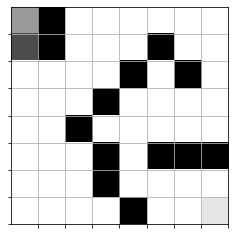

In [13]:
qmaze = Qmaze(maze)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)

Here is a drawing of the maze after performing the following 5 moves:

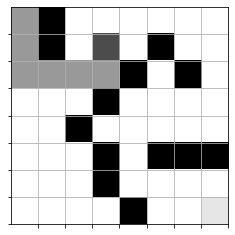

In [14]:
qmaze.act(DOWN)  # move down
qmaze.act(RIGHT)  # move right
qmaze.act(RIGHT)  # move right
qmaze.act(RIGHT)  # move right
qmaze.act(UP)  # move up
show(qmaze)

Indeed, it is now very simple to write a function for simulating a full game
according to a given model (trained neural network).
This function acceps the following three arguments:
1. **model** - a trained neural network which calculates the next action
2. **qmaze** - A Qmaze object
3. **rat_cell** - the starting cell of the rat

In [15]:
def play_game(model, qmaze, rat_cell):
    qmaze.reset(rat_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model(torch.from_numpy(prev_envstate).float()).detach().numpy()
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True, qmaze
        elif game_status == 'lose':
            return False, qmaze

### Completion Check
For small mazes we can allow ourselves to perform a **completion check**
in which we simulate all possible games and check if our model wins them all.
This is not practical for large mazes as it slows down training significantly.

In [57]:
def completion_check(model, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False
    return True

## Markov Decision Process for Maze Environment

A Reinforcement Learning system consists of an <b>environment</b> and
a dynamic <b>agent</b> which acts in this environment
in finite discrete list of time steps.

<ol>
<li> At every time step $t$, the agent is entering a state $s$,
and needs to choose an action $a$ from a fixed set of possible actions.
The decision about which action to take should depend on the current state only
(previous actions history is irrelevant).
This is sometimes refered to as <b>MDP: Markov Decision Process</b> (or shortly Markov Chain).

<li>
The result of performing action $a$ at time $t$ will result in a transition
from a current state $s$ at time $t$ to a new state $s'=T(s,a)$ at time $t+1$,
and an immediate reward $r=R(s,a)$ (numerical value) which is collected by the agent
after each action (could be called a "penalty" in case the reward is negative).
$T$ is usually called the <b>transition function</b>, and $R$ is the <b>reward function</b>:

\begin{align}
s' & = T(s,a) \\
r  & = R(s,a)
\end{align}

<li> The agent's goal is to collect the maximal total reward during a "game".
The greedy policy of choosing the action that yields the highest immediate reward at state $s$,
may not lead to the best possible total reward as it may happen that
after one "lucky" strike all the subsequent moves will yield poor rewards or even penalties.
Therefore, selecting the optimal route is a real and difficult challenge
(just as it is in life, delayed rewards are hard to get by).

<li> In the following figure we see a Markov chain of 5 states of a rat in a maze game.
The reward for every legal move is $-0.04$ which is actually a "small penalty".
The reason for this is that we want to minimize the rat's route to the cheese.
The more the rat wonders around and wastes time, the less reward it gets.
When the rat reaches the cheese cell, it gets the maximal reward of $1.0$
(all rewards are ranging from $-1.0$ to $1.0$)

<img src="mdp1.png" width="750" align="center">



Note that each state consists of all the available cells information,
including the rat location.
In our Python code, each state is represented by a vector of length
64 (for an 8x8 maze) with gray values 0.0 to 1.0:
an occupied cell is 0.0, a free cell is 1.0, and the rat cell is 0.5.
History (yellow cells) is not recorded since the next move should not depend on past moves!

<li> If our agent takes the action sequence (starting at state $s1$ till the game end):
$a_1$, $a_2$, $a_3$, ..., $a_{n}$,
then the resulting total reward for this sequence is:
$$
A = R(s_1, a_1) + R(s_2, a_2) + \cdots + R(s_n, a_n)
$$
Our goal is to find a <b>policy</b> function $\pi$ that maps a maze
state $s$ to an "optimal" action $a$ that we should take in order
to maximize our total reward $A$.
The policy $\pi$ tells us what action to take in whatever state $s$ we are in
by simply applying it on the given state $s$:
$$
\text{action} = \pi(s)
$$
A <b>policy</b> function is sometimes best illustrated by a <b>policy diagram</b>:

<img src="policy_10x10.png" width="300" align="center">



<li>
Once we have a policy function $\pi$, all we need to do is to follow it blindly:
\begin{align}
a_1  & =  \pi(s_1) \\
s_2  & =  T(s_1, a_1) \\
a_2  & =  \pi(s_2) \\
\cdots & =  \cdots \\
a_n  & = \pi(s_{n-1})
\end{align}
So playing the maze is now becoming an automatic pilot flight.
We simply ask $\pi$ what to do in each state and we're guaranteed to end the game with
the maximal reward.

<li>
But how are we supposed to find $\pi$?
From a game-theoretic point of view, it is known to be quite a difficult challenge,
especially for large board games such as <b>GO</b> (for which no classical
game theoretic solution is known).

</ol>



## Q-Learning and Bellman Equation
The trick that was used by startups such as Google DeepMind for finding $\pi$ was to start
with a different kind of function $Q(s,a)$ called **best utility function**
(and sometimes **best quality function**,
from which the **Q** letter and **Q-learning** terms were coined).

The definition of $Q(s,a)$ is simple:
$$
Q(s,a) = \text{the maximum total reward we can get by choosing action $a$ in state $s$}
$$
At least for our maze solving, it is easy to be convinced that such function exists,
although we have no idea how to compute it efficiently
(except for going through all possible Markov chains that start at state $s$,
which is insanely inefficient).
But it can also be proved mathematically for all similar Markov systems.

Once we have $Q(s,a)$ at hand, finding a policy function is easy!
$$
\newcommand{\argmax}{\mathop{\mathrm{argmax}}} 
\pi(s) = \argmax_{i=0,1,\ldots,n-1} Q(s,a_i)
$$
That is: we calculate $Q(s,a_i)$ for all actions $a_i$,
$i=0,1,\ldots,n-1$ (where $n$ is the number of actions),
and select the action $a_i$
for which $Q(s,a_i)$ is maximal.
This is obviously the way to go.
But we do not have the function $Q(s,a)$ yet ... how do we get it?

It turns out that the function $Q(s,a)$ has a simple **recursive property**
which characterizes it, and also helps to approximate it.
It is called **Bellman's Equation** and it is obvious from first sight:
$$
Q(s,a) = R(s,a) + \max_{i=0,1,\ldots,n-1} Q(s',a_i), \quad \text{(where $s' = T(s,a)$)}
$$
In simple words: the value $Q(s,a)$ is equal to the immediate reward $R(s,a)$
plus the maximal value of $Q(s',a_j)$, where $s'$ is the next state and $a_i$ 
is an action.

In addition, Bellman's Equation is also a unique
characterization of the best utility function.
That is, if a function $Q(s,a)$ satisfies the Bellman Equation then it must be the best utility
function.

To approximate $Q(s,a)$ we will build a neural network $N$ which accepts a state $s$
as input and outputs a vector $q$ of **q-values** corresponding to our $n$ actions:
$q = (q_0, q_1, q_2, \cdots, q_{n-1})$,
where $q_i$ should approximate the value $Q(s, a_i)$,
for each action $a_i$.
Once the network is sufficiently trained and accurate,
we will use it to define a policy, which we call **the derived policy**, as follows
$$
\begin{align}
q & = N[s] \\
j & = \argmax_{i=0,1,\ldots, n-1} (q_0, q_1, \ldots, q_{n-1}) \\
\pi(s) & = a_j
\end{align}
$$

## Q-Training
The question now is how we train our neural network $N$.
The usual arrangement (as we've seen a lot) is to generate a sufficiently
large dataset of $(e,q)$ pairs, where $e$ is an **environment state**
(or maze state in our case),
and $q = (q_0, q_1, \ldots, q_{n-1})$ are the correct actions' q-values.
To do this, we will have to simulate thousands of games and make sure that
all our moves are optimal (or else our q-values may not be correct).
This is of course too tedious, too hard,
and impractical in most real life cases.

Deep learning startups (like Google DeepMind) came up with more practical and surprisingly
elegant schemes for tackling this problem.
We will explore one of them (thanks to
[Eder Santana](https://gist.github.com/EderSantana)
post which included a small and clear demonstration).

1. We will generate our training samples from using the neural network $N$ itself,
by simulating hundreds or thousands of games.
We will **exploit** the **derived policy** $\pi$ (from the last section)
to make 90% of our game moves
(the other 10% of the moves are reserved for exploration).
However we will set the target function of our neural network $N$
to be the function in the right side of Bellman's equation!
Assuming that our neural network $N$ converges,
it will define a function $Q(s,a)$ which satisfies Bellman's equation,
and therefore it must be the best utility function which we seek. 

2. The training of $N$ will be done after each game move
by injecting a random selection of the most recent training samples to $N$.
Assuming that our game skill will get better in time,
we will use only a small number of the most recent training samples.
We will forget old samples (which are probably bad) and will delete them
from memory.

3. In more detail: After each game move we will generate an **episode** and
save it to a short term memory sequence.
An **episode** is a tuple of 5 elements that we need for one training:

    **episode = [envstate, action, reward, envstate_next, game_over]** 

    (a) **envstate** - environment state.
    In our maze case it means a full picture of the maze cells
    (the state of each cell including rat and chees location)
    To make it easier for our neural network, we squash the maze to a 1-dimensional
    vector that fits the networks input.
    
    (b) **action** - one of the four actions that the rat can do to move on the maze:
            0 - left
            1 - up
            2 - right
            3 - down
    (c) **reward** - is the reward received from the action
    
    (d) **envstate_next** - this is the new maze environment state which resulted
    from the last action
    
    (e) **game_over** - this is a boolean value (True/False) which indicates
    if the game is over or not.
    The game is over if the rat has reached the cheese cell (win),
    or of the rat has reached a negative reward limit (lose).

After each move in the game, we form this 5-elements episode and insert it
to our memory sequence. In case that our memory sequence size grows beyond
a fixed bound we delete elements from its tail to keep it below this bound.

The weights of network $N$ are initialized with random values,
so in the beginning $N$ will produce awful results, but if our model parameters are chosen
properly, it should converge to a solution of the Bellman Equation, and therefore
later experiments are expected to be more truthful.
Currently, building model that converges quickly seems to be very difficult and
there is still lots of room for improvements in this issue.

## The Experience Class
This is the class in which we collect our game episodes (or game experiences)
within a memory list.
Note that its initialization methods need to get a
1. **model** - a neural network model
2. **max_memory** - maximal length of episodes to keep.
   When we reach the maximal lenght of memory,
   each time we add a new episode, the oldest episode is deleted
3. **discount factor** - this is a special coefficient, usually denoted by $\gamma$
   which is required for the Bellman equation for stochastic environments
   (in which state transitions are probabilistic).
   Here is a more practical version of the Bellman equation:
$$
Q(s,a) = R(s,a) + \gamma \cdot \max_{i=0,\ldots,n-1} Q(s',a_i), \quad \text{(where $s' = T(s,a)$)}
$$

In [58]:
class Experience(object):
    def __init__(self, model, max_memory=100, discount=0.95):
        self.model = model
        self.max_memory = max_memory
        self.discount = discount
        self.memory = list()
        self.num_actions = model.layers[-1].out_features
        
    def remember(self, episode):
        # episode = [envstate, action, reward, envstate_next, game_over]
        # memory[i] = episode
        # envstate == flattened 1d maze cells info, including rat cell (see method: observe)
        self.memory.append(episode)
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def predict(self, envstate):
        return self.model(torch.from_numpy(envstate).float().flatten()) #[0]

    def get_data(self, data_size=10):
        env_size = self.memory[0][0].shape[1]   # envstate 1d size (1st element of episode)
        mem_size = len(self.memory)
        data_size = min(mem_size, data_size)
        inputs = np.zeros((data_size, env_size))
        targets = np.zeros((data_size, self.num_actions))
        for i, j in enumerate(np.random.choice(range(mem_size), data_size, replace=False)):
            envstate, action, reward, envstate_next, game_over = self.memory[j]
            inputs[i] = envstate
            # There should be no target values for actions not taken.
            targets[i] = self.predict(envstate).detach().numpy()
            # Q_sa = derived policy = max quality env/action = max_a' Q(s', a')
            Q_sa = torch.max(self.predict(envstate_next))
            if game_over:
                targets[i, action] = reward
            else:
                # reward + gamma * max_a' Q(s', a')
                targets[i, action] = reward + self.discount * Q_sa
        return inputs, targets


## The Q-Training Algorithm for Qmaze
Following is the algorithm fortraining a our neural network model to solve the maze.
It accepts a keyword argument list.
Here are the most significant options:
1. **n_epoch** - Number of training epochs
2. **max_memory** - Maximum number of game experiences we keep in memory
   (see the **Experince** class above)
3. **data_size** - Number of samples we use in each training epoch.
   This is the number episodes (or game experiences) which we randomly select from
   our experiences repository (again, see the **Experience** class above)

In [59]:
def qtrain(model, maze, **opt):
    global epsilon
    n_epoch = opt.get('n_epoch', 15000)
    max_memory = opt.get('max_memory', 1000)
    data_size = opt.get('data_size', 50)
    weights_file = opt.get('weights_file', "")
    name = opt.get('name', 'model')
    start_time = datetime.datetime.now()

    # If you want to continue training from a previous model,
    # just supply the h5 file name to weights_file option
    if weights_file:
        print("loading weights from file: %s" % (weights_file,))
        #model.load_weights(weights_file)
        model_w = torch.load(weights_file)
        model.load_state_dict(model_w )
        
    # Construct environment/game from numpy array: maze (see above)
    qmaze = Qmaze(maze)

    # Initialize experience replay object
    experience = Experience(model, max_memory=max_memory)

    win_history = []   # history of win/lose game
    n_free_cells = len(qmaze.free_cells)
    hsize = qmaze.maze.size//2   # history window size
    win_rate = 0.0
    imctr = 1

    for epoch in range(n_epoch):
        loss = 0.0
        rat_cell = random.choice(qmaze.free_cells)
        qmaze.reset(rat_cell)
        game_over = False

        # get initial envstate (1d flattened canvas)
        envstate = qmaze.observe()

        n_episodes = 0
        while not game_over:
            valid_actions = qmaze.valid_actions()
            if not valid_actions: break
            prev_envstate = envstate
            # Get next action
            if np.random.rand() < epsilon:
                action = random.choice(valid_actions)
            else:
                action = torch.argmax(experience.predict(prev_envstate))

            # Apply action, get reward and new envstate
            envstate, reward, game_status = qmaze.act(action)
            if game_status == 'win':
                win_history.append(1)
                game_over = True
            elif game_status == 'lose':
                win_history.append(0)
                game_over = True
            else:
                game_over = False

            # Store episode (experience)
            episode = [prev_envstate, action, reward, envstate, game_over]
            experience.remember(episode)
            n_episodes += 1

            # Train neural network model
            inputs, targets = experience.get_data(data_size=data_size)
            h = model.train(
                        inputs, targets,
                        optimiser_type = "SGD",learning_rate=0.01,
                        epochs=20,batch_size=16,verbose=0,
                         )
            loss_function = torch.nn.MSELoss()
            loss = loss_function(model(torch.from_numpy(inputs).float()), torch.from_numpy(targets).flatten())

        if len(win_history) > hsize:
            win_rate = sum(win_history[-hsize:]) / hsize
    
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
        print(template.format(epoch, n_epoch-1, loss, n_episodes, sum(win_history), win_rate, t))
        # we simply check if training has exhausted all free cells and if in all
        # cases the agent won
        if win_rate > 0.9 : epsilon = 0.05
        if sum(win_history[-hsize:]) == hsize and completion_check(model, qmaze):
            print("Reached 100%% win rate at epoch: %d" % (epoch,))
            break

    # Save trained model weights and architecture, this will be used by the visualization code
    pth_file=name+".pth"
    torch.save(model.state_dict(), pth_file)

    #json_file = name + ".json"
    #with open(json_file, "w") as outfile:
    #    json.dump(model.to_json(), outfile)
    end_time = datetime.datetime.now()
    dt = datetime.datetime.now() - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)
    print('files: %s' % (pth_file))
    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (epoch, max_memory, data_size, t))
    return seconds

# This is a small utility for printing readable time strings:
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)

## Building a Neural Network Model
Choosing the correct parameters for a suitable model is not easy and requires
some experience and many experiments.
In the case of a maze we found that:
1. The most suitable activation function is **SReLU** (the S-shaped relu) (we use **PReLU** for now)
2. Our optimizer is **SGD** for now
3. Our loss function is **mse** (Mean Squared Error).

We use two hidden layers, each of their size equals to the maze size.
The input layer has also the same size as the maze since it accepts the maze state as input.
The output layer size is the same as the number of actions (4 in our case),
since it outputs the estimated q-value for each action.
(we need to take the action with the maximal q-value for playing the game).

In [60]:
from torch.utils.data import DataLoader, TensorDataset

In [61]:
class NN(torch.nn.Module):
    def __init__(self, maze):
        super(NN, self).__init__()
        self.layers = Sequential(
            Linear(maze.size,maze.size),
            PReLU(),
            Linear(maze.size,maze.size),
            PReLU(),
            Linear(maze.size,num_actions))
    # Specify the computations performed on the data
    def forward(self, x):
        """
        Defines the forward pass through the above defined structure

        Args:
          x: torch.Tensor
            Input tensor of size ([3])

        Returns:
          layers: nn.module
            Initialised Layers in order to re-use the same layer for each forward pass of data you make.
        """
        # Pass the data through the layers
        return self.layers(x).flatten() #torch.from_numpy(x).float().flatten())
    
    def train(self, inputs_np, targets_np,optimiser_type = "SGD",learning_rate=0.01, epochs=8, batch_size=1, verbose=0):
        # The Cross Entropy Loss is suitable for classification problems
        inputs = torch.from_numpy(inputs_np).float()
        targets = torch.from_numpy(targets_np).float()
        
        loss_function = torch.nn.MSELoss()

        # Create an optimizer that will be used to train the network
        if optimiser_type == "SGD":
            optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

        # List of losses for visualization
        losses = []

        dataset = TensorDataset(inputs, targets)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        for i in range(epochs):
            # Pass the data through the network and compute the loss
            # We'll use the whole dataset during the training instead of using batches
            # in to order to keep the code simple for now.

            epoch_loss = 0.0
            for inputs_batch, targets_batch in dataloader:
                optimizer.zero_grad()
                outputs = self(inputs_batch)
                loss = loss_function(outputs.flatten(), targets_batch.flatten())
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            epoch_loss /= len(dataloader)
            losses.append(epoch_loss)
            if verbose:
                print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.6f}")
        
        return losses



## Small Q-test
Lets test our algorithm on the following small (7x7) maze

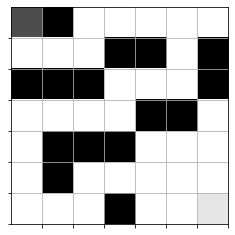

In [62]:
'''
maze =  np.array([
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  0.,  1.,  0.],
    [ 0.,  0.,  0.,  1.,  1.,  1.,  0.],
    [ 1.,  1.,  1.,  1.,  0.,  0.,  1.],
    [ 1.,  0.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

'''

maze =  np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  0.,  1.,  0.],
    [ 0.,  0.,  0.,  1.,  1.,  1.,  0.],
    [ 1.,  1.,  1.,  1.,  0.,  0.,  1.],
    [ 1.,  0.,  0.,  0.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.]
])


qmaze = Qmaze(maze)
show(qmaze)

maze =  np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1],
    [ 1.,  1.,  1.,  1.,  0.,  0.],
    [ 0.,  0.,  0.,  1.,  1.,  0.],
    [ 1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  0.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.]
])

qmaze = Qmaze(maze)
show(qmaze)

In [63]:
model = NN(maze)
qtrain(model, maze, n_epoch=5000, max_memory=8*maze.size, data_size=32)

Epoch: 000/4999 | Loss: 0.0019 | Episodes: 107 | Win count: 0 | Win rate: 0.000 | time: 3.2 seconds
Epoch: 001/4999 | Loss: 0.0673 | Episodes: 105 | Win count: 0 | Win rate: 0.000 | time: 6.8 seconds
Epoch: 002/4999 | Loss: 0.0745 | Episodes: 104 | Win count: 0 | Win rate: 0.000 | time: 10.2 seconds
Epoch: 003/4999 | Loss: 0.0759 | Episodes: 104 | Win count: 0 | Win rate: 0.000 | time: 13.8 seconds
Epoch: 004/4999 | Loss: 0.0011 | Episodes: 105 | Win count: 0 | Win rate: 0.000 | time: 17.2 seconds
Epoch: 005/4999 | Loss: 0.1447 | Episodes: 108 | Win count: 0 | Win rate: 0.000 | time: 20.6 seconds
Epoch: 006/4999 | Loss: 0.0012 | Episodes: 99 | Win count: 0 | Win rate: 0.000 | time: 23.8 seconds
Epoch: 007/4999 | Loss: 0.0015 | Episodes: 104 | Win count: 0 | Win rate: 0.000 | time: 27.2 seconds
Epoch: 008/4999 | Loss: 0.0008 | Episodes: 106 | Win count: 0 | Win rate: 0.000 | time: 30.9 seconds
Epoch: 009/4999 | Loss: 0.0025 | Episodes: 104 | Win count: 0 | Win rate: 0.000 | time: 34.4 s

Epoch: 082/4999 | Loss: 0.0073 | Episodes: 100 | Win count: 33 | Win rate: 0.500 | time: 185.6 seconds
Epoch: 083/4999 | Loss: 0.0051 | Episodes: 3 | Win count: 34 | Win rate: 0.542 | time: 185.7 seconds
Epoch: 084/4999 | Loss: 0.0195 | Episodes: 106 | Win count: 34 | Win rate: 0.500 | time: 189.1 seconds
Epoch: 085/4999 | Loss: 0.0018 | Episodes: 3 | Win count: 35 | Win rate: 0.542 | time: 189.2 seconds
Epoch: 086/4999 | Loss: 0.0070 | Episodes: 3 | Win count: 36 | Win rate: 0.583 | time: 189.3 seconds
Epoch: 087/4999 | Loss: 0.0180 | Episodes: 105 | Win count: 36 | Win rate: 0.542 | time: 192.6 seconds
Epoch: 088/4999 | Loss: 0.0014 | Episodes: 100 | Win count: 36 | Win rate: 0.542 | time: 196.0 seconds
Epoch: 089/4999 | Loss: 0.0014 | Episodes: 3 | Win count: 37 | Win rate: 0.542 | time: 196.1 seconds
Epoch: 090/4999 | Loss: 0.0015 | Episodes: 4 | Win count: 38 | Win rate: 0.542 | time: 196.2 seconds
Epoch: 091/4999 | Loss: 0.0741 | Episodes: 4 | Win count: 39 | Win rate: 0.542 | ti

Epoch: 163/4999 | Loss: 0.0018 | Episodes: 101 | Win count: 93 | Win rate: 0.708 | time: 271.8 seconds
Epoch: 164/4999 | Loss: 0.0022 | Episodes: 7 | Win count: 94 | Win rate: 0.750 | time: 272.0 seconds
Epoch: 165/4999 | Loss: 0.0012 | Episodes: 20 | Win count: 95 | Win rate: 0.750 | time: 272.7 seconds
Epoch: 166/4999 | Loss: 0.0033 | Episodes: 18 | Win count: 96 | Win rate: 0.750 | time: 273.3 seconds
Epoch: 167/4999 | Loss: 0.0036 | Episodes: 14 | Win count: 97 | Win rate: 0.792 | time: 273.8 seconds
Epoch: 168/4999 | Loss: 0.0068 | Episodes: 17 | Win count: 98 | Win rate: 0.833 | time: 274.4 seconds
Epoch: 169/4999 | Loss: 0.0013 | Episodes: 12 | Win count: 99 | Win rate: 0.833 | time: 274.8 seconds
Epoch: 170/4999 | Loss: 0.0018 | Episodes: 101 | Win count: 99 | Win rate: 0.833 | time: 278.2 seconds
Epoch: 171/4999 | Loss: 0.0016 | Episodes: 4 | Win count: 100 | Win rate: 0.833 | time: 278.4 seconds
Epoch: 172/4999 | Loss: 0.0021 | Episodes: 2 | Win count: 101 | Win rate: 0.833 |

299.490838

### Let's look at how the model works on the maze by simulating some games

win


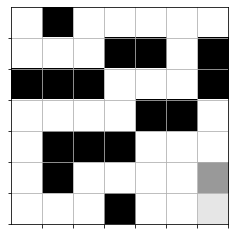

win


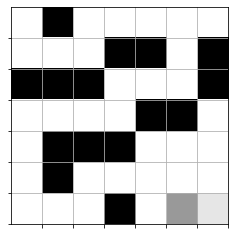

lose


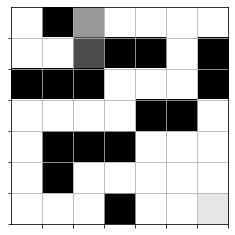

win


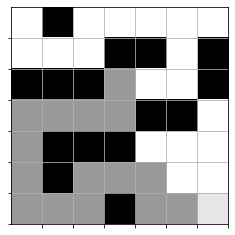

win


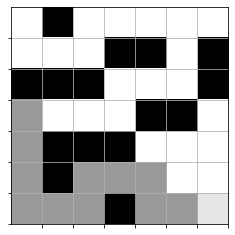

lose


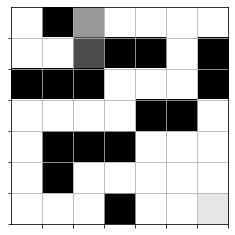

win


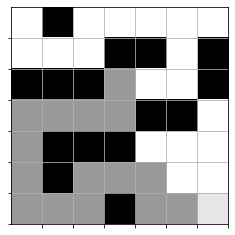

win


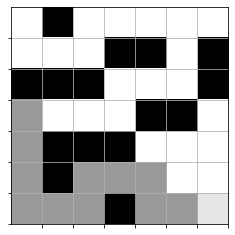

win


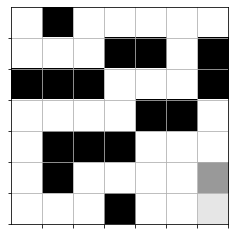

win


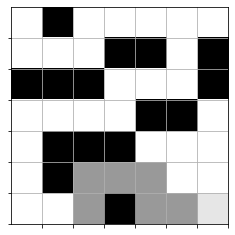

In [64]:
# Test model
max_memory=10
experience = Experience(model, max_memory=max_memory*maze.size)

win_history = []   # history of win/lose game
n_free_cells = len(qmaze.free_cells)
for _i in range(10):
    rat_cell = random.choice(qmaze.free_cells)
    qmaze.reset(rat_cell)

    hsize = qmaze.maze.size//2   # history window size
    epsilon = 0.0
    envstate = qmaze.observe()
    n_episodes = 0
    game_over=False
    while not game_over:

        valid_actions = qmaze.valid_actions()
        if not valid_actions: break
        prev_envstate = envstate
        # Get next action

        if np.random.rand() < epsilon:
            action = random.choice(valid_actions)
        else:
            action = torch.argmax(experience.predict(prev_envstate))

        # Apply action, get reward and new envstate
        envstate, reward, game_status = qmaze.act(action)


        #print(game_status)
        if game_status == 'win':
            win_history.append(1)
            game_over = True
        elif game_status == 'lose':
            win_history.append(0)
            game_over = True
        else:
            game_over = False

        # Store episode (experience)
        episode = [prev_envstate, action, reward, envstate, game_over]
        experience.remember(episode)
        n_episodes += 1

    print(game_status)
    show(qmaze)
    plt.show()


# Additional Ideas for Course Projects

1. A more challenging maze problem is a cat/mouse chase puzzle in which the blocked
   cells, as well as the mouse are moving in time.
   This is the type of problems in which classical algorithms are starting to get rough
   and deep learning techniques could provide better answers.
2. There are plenty of variations on the above type of games.
   We can for example add a cheese to the maze and then we have a double-chase scene:
   the cat chases the mouse, and the mouse chases the moving cheese.
   This is also known as
   [the Theseus and Minotaur Maze](http://lafarren.com/theseus-minotaur-solver),
   and it belongs to the multi-agent type of problems.
   Current Reinforcement Learning techniques are still in their infancy and there's 
   a vast room for further reseach and development.
3. We can throw several pieces of cheese to the maze and the rat will have to find the shortest
   route for collecting all of them.
   Of course, we can also add complications like moving cells and moving cheese, but it seems like
   the static version is hard enough.
4. There are also 3-dimensional versions of these maze problems, which are hard to visualize,
   and probably much harder to solve, but sooner or later they must be used for testing,
   validating, and enhancing deep reinforcement learning techniques.
5. In our next notebook we will explore the "Tour De Flags" maze in which an agent has to collect
   a group of flags and deliver them to a target cell. The agent must find a shortest route
   for doing so. The agent receives bonus points for collecting each flag, and receives the full
   award when it arrives to the target cell. Here is a small glimpse to this topic:
   


<img src="12x12_1.gif" style="max-width: 40%;" />




### Resources
1. [Solving the maze using Keras](https://www.samyzaf.com/ML/rl/qmaze.html)
2. [Demystifying Deep Reinforcement Learning](https://www.nervanasys.com/demystifying-deep-reinforcement-learning)
3. [Keras plays catch, a single file Reinforcement Learning example](http://edersantana.github.io/articles/keras_rl)
4. [Q-learning](https://en.wikipedia.org/wiki/Q-learning)
5. [Keras plays catch - code example](https://gist.github.com/EderSantana/c7222daa328f0e885093)
6. [Reinforcement learning using chaotic exploration in maze world](http://ieeexplore.ieee.org/document/1491636)
7. [Neural Combinatorial Optimization with Reinforcement Learning](https://arxiv.org/abs/1611.09940)
8. [How DeepMind’s Memory Trick Helps AI Learn Faster](https://www.technologyreview.com/s/603868/how-deepminds-memory-trick-helps-ai-learn-faster/?imm_mid=0ef03f&cmp=em-data-na-na-newsltr_20170320)
9. [Introduction to Reinforcement Learning](http://www.cs.indiana.edu/~gasser/Salsa/rl.html)
10. [Reward function and initial values: Better choices for
accelerated Goal-directed reinforcement learning](https://hal.archives-ouvertes.fr/hal-00331752/document)
11. [Andrej Karpathi blog: Deep Reinforcement Learning: Pong from Pixels](http://karpathy.github.io/2016/05/31/rl/)
12. [Dijkstra shortest path algorithm:](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm) the most practical method for solving mazes